# StyleGAN2-ADA PyTorch Generation

See
https://github.com/NVlabs/stylegan2-ada-pytorch

First install all required python packages

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -q imageio-ffmpeg==0.4.3 pyspng==0.1.0 click tqdm requests psutil torch ninja 

     |████████████████████████████████| 26.9MB 47.7MB/s 
     |████████████████████████████████| 204kB 59.8MB/s 
     |████████████████████████████████| 112kB 62.6MB/s 


Checking out the StyleGAN codebase

In [ ]:
!git clone -q https://github.com/NVlabs/stylegan2-ada-pytorch


## Data repository

| Path | Description
| :--- | :----------
| [stylegan2-ada-pytorch](https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/) | Main directory hosted on Amazon S3
| &ensp;&ensp;&boxvr;&nbsp; [ada-paper.pdf](https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/ada-paper.pdf) | Paper PDF
| &ensp;&ensp;&boxvr;&nbsp; [images](https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/images/) | Curated example images produced using the pre-trained models
| &ensp;&ensp;&boxvr;&nbsp; [videos](https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/videos/) | Curated example interpolation videos
| &ensp;&ensp;&boxur;&nbsp; [pretrained](https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/) | Pre-trained models
| &ensp;&ensp;&ensp;&ensp;&boxvr;&nbsp; ffhq.pkl | FFHQ at 1024x1024, trained using original StyleGAN2
| &ensp;&ensp;&ensp;&ensp;&boxvr;&nbsp; metfaces.pkl | MetFaces at 1024x1024, transfer learning from FFHQ using ADA
| &ensp;&ensp;&ensp;&ensp;&boxvr;&nbsp; afhqcat.pkl | AFHQ Cat at 512x512, trained from scratch using ADA
| &ensp;&ensp;&ensp;&ensp;&boxvr;&nbsp; afhqdog.pkl | AFHQ Dog at 512x512, trained from scratch using ADA
| &ensp;&ensp;&ensp;&ensp;&boxvr;&nbsp; afhqwild.pkl | AFHQ Wild at 512x512, trained from scratch using ADA
| &ensp;&ensp;&ensp;&ensp;&boxvr;&nbsp; cifar10.pkl | Class-conditional CIFAR-10 at 32x32
| &ensp;&ensp;&ensp;&ensp;&boxvr;&nbsp; brecahad.pkl | BreCaHAD at 512x512, trained from scratch using ADA
| &ensp;&ensp;&ensp;&ensp;&boxvr;&nbsp; [paper-fig7c-training-set-sweeps](https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/paper-fig7c-training-set-sweeps/) | Models used in Fig.7c (sweep over training set size)
| &ensp;&ensp;&ensp;&ensp;&boxvr;&nbsp; [paper-fig11a-small-datasets](https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/paper-fig11a-small-datasets/) | Models used in Fig.11a (small datasets & transfer learning)
| &ensp;&ensp;&ensp;&ensp;&boxvr;&nbsp; [paper-fig11b-cifar10](https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/paper-fig11b-cifar10/) | Models used in Fig.11b (CIFAR-10)
| &ensp;&ensp;&ensp;&ensp;&boxvr;&nbsp; [transfer-learning-source-nets](https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/transfer-learning-source-nets/) | Models used as starting point for transfer learning
| &ensp;&ensp;&ensp;&ensp;&boxur;&nbsp; [metrics](https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/metrics/) | Feature detectors used by the quality metrics


In [ ]:
# This code is for getting the pretrained model
//!wget https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/transfer-learning-source-nets/ffhq-res256-mirror-paper256-noaug.pkl

--2021-02-17 10:53:42--  https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/transfer-learning-source-nets/ffhq-res256-mirror-paper256-noaug.pkl
Resolving nvlabs-fi-cdn.nvidia.com (nvlabs-fi-cdn.nvidia.com)... 65.8.248.73, 65.8.248.9, 65.8.248.127, ...
Connecting to nvlabs-fi-cdn.nvidia.com (nvlabs-fi-cdn.nvidia.com)|65.8.248.73|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 295744285 (282M) [binary/octet-stream]
Saving to: ‘ffhq-res256-mirror-paper256-noaug.pkl’

ffhq-res256-mirror- 100%[===================>] 282.04M   108MB/s    in 2.6s    

2021-02-17 10:53:46 (108 MB/s) - ‘ffhq-res256-mirror-paper256-noaug.pkl’ saved [295744285/295744285]



In [ ]:
# Use your own PKL file from GDrive here!!
network_pkl = "/content/drive/MyDrive/MachineLearning/stylegan-out/00008-flickrMarineBiology_1024-mirror-auto1-kimg200-ada-resumecustom/network-snapshot-000084.pkl"
outdir = "out"

import sys
sys.path.append("stylegan2-ada-pytorch")

import os
import re
import dnnlib
import numpy as np
import PIL.Image
import torch
import legacy
import imageio
import projector
import io
from google.colab import files

from tqdm.notebook import tqdm

print('Loading networks from "%s"...' % network_pkl)

# Check if a GPU is available
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("Using GPU")
else:
    device = torch.device('cpu')
    print("Using CPU")

with dnnlib.util.open_url(network_pkl) as f:
    G = legacy.load_network_pkl(f)['G_ema'].to(device)

def gen(w):
    img = G.synthesis(w.unsqueeze(0).to(device), noise_mode='const')
    img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
    return img


def img_fromarray(img):
    return PIL.Image.fromarray(img[0].cpu().numpy(), 'RGB')


def gen_img(w):
    return img_fromarray(gen(w))


def load_img(fname):
    img = PIL.Image.open(fname).convert('RGB')
    w, h = img.size
    s = min(w, h)
    img = img.crop(((w - s) // 2, (h - s) // 2, (w + s) // 2, (h + s) // 2))
    img = img.resize((G.img_resolution, G.img_resolution), PIL.Image.LANCZOS)
    return np.array(img, dtype=np.uint8)


def slerp(low, high, val):
    low_norm = low / torch.norm(low, dim=1, keepdim=True)
    high_norm = high / torch.norm(high, dim=1, keepdim=True)
    omega = torch.acos((low_norm*high_norm).sum(1))
    so = torch.sin(omega)
    res = (torch.sin((1.0-val)*omega)/so).unsqueeze(1)*low + (torch.sin(val*omega)/so).unsqueeze(1) * high
    return res


def latent_walk_video(fname, start, end, steps=20):
    video = imageio.get_writer(fname)
    for i in tqdm(np.arange(0, 1, 1.0 / steps)):
        w = slerp(start, end, i)
        img = gen(w.to(device))[0].cpu().numpy()
        video.append_data(img)
    video.close()


def rand_w(truncation_psi):
    z = torch.randn(1, 512)
    w = G.mapping(z.to(device), None)[0]
    w_avg = G.mapping.w_avg
    w = w_avg + (w - w_avg) * truncation_psi
    return w

# higher truncation psi means less realistic (above 1.0)
def random_latent_walk_video(fname, keyframes, truncation_psi=1.0):
    step_size = 0.01
    video = imageio.get_writer(fname)
    rand_ws = [rand_w(truncation_psi) for _ in range(keyframes)]
    start = rand_ws[0]
    for end in tqdm(rand_ws[1:]):
        for i in np.arange(0, 1, step_size):
            w = slerp(start, end, i)
            img = gen(w.to(device))[0].cpu().numpy()
            video.append_data(img)
        start = end
    video.close()


def upload_img():
    uploaded = files.upload()
    img_bytes = list(uploaded.values())[0]
    img = load_img(io.BytesIO(img_bytes))
    img = torch.from_numpy(img.transpose(2, 0, 1))
    return img

Loading networks from "/content/drive/MyDrive/MachineLearning/stylegan-out/00008-flickrMarineBiology_1024-mirror-auto1-kimg200-ada-resumecustom/network-snapshot-000084.pkl"...
Using GPU


Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.


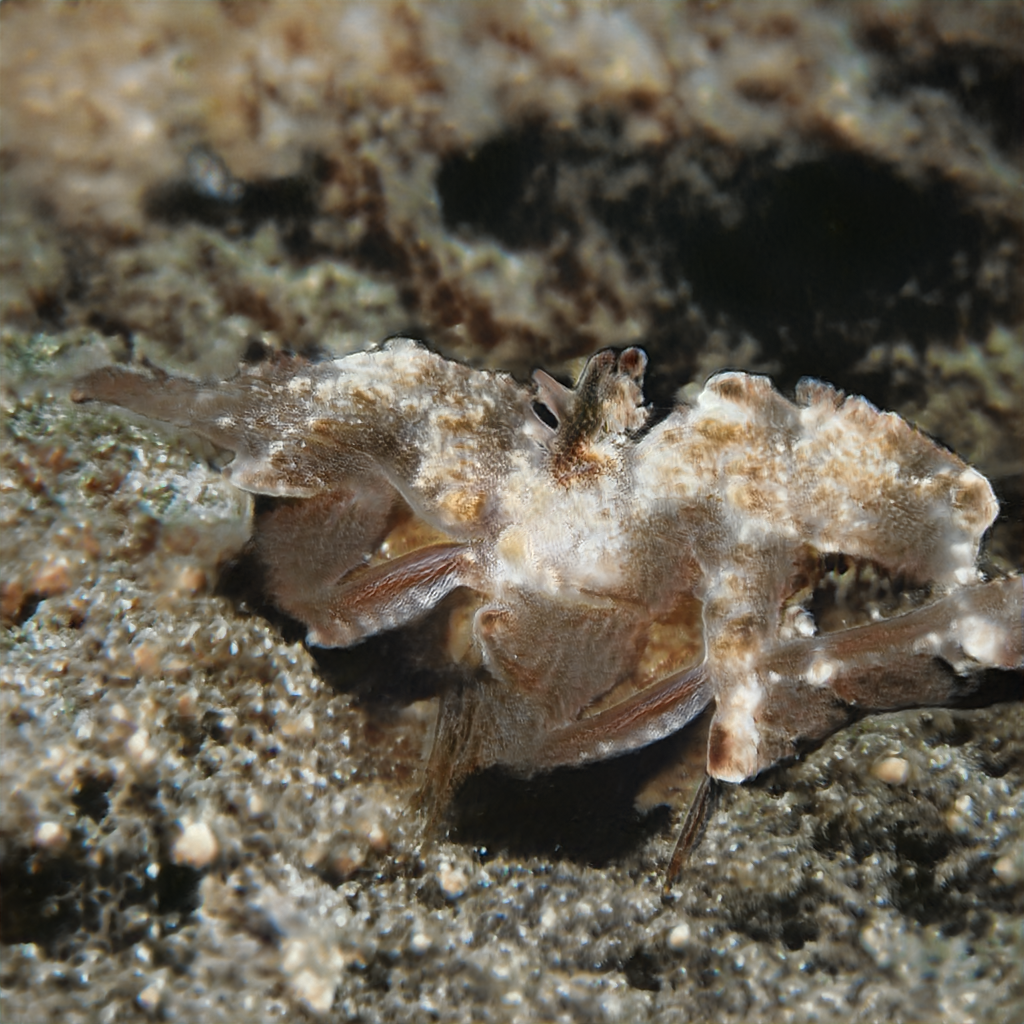

In [ ]:
# Generate the average image
gen_img(rand_w(0))

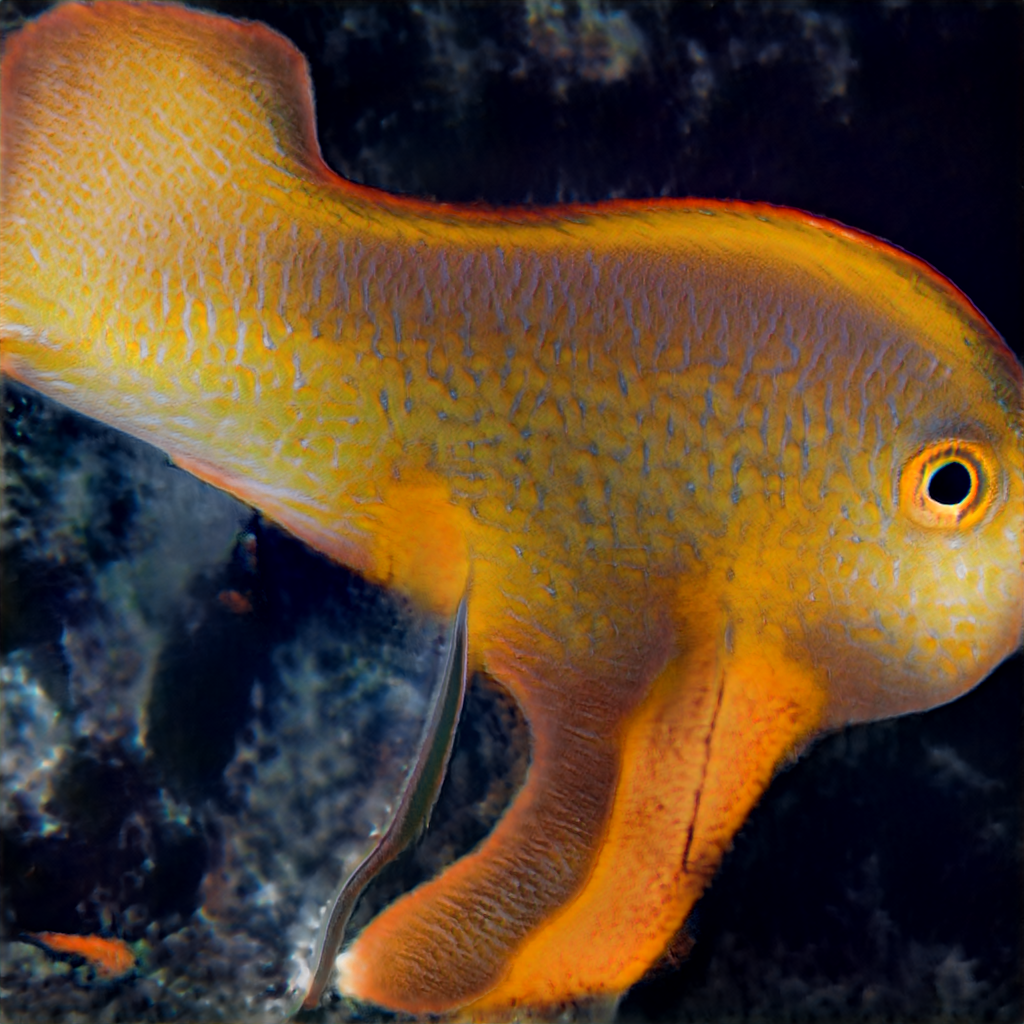

In [ ]:
# Generate a random but realistic image
gen_img(rand_w(1.5))

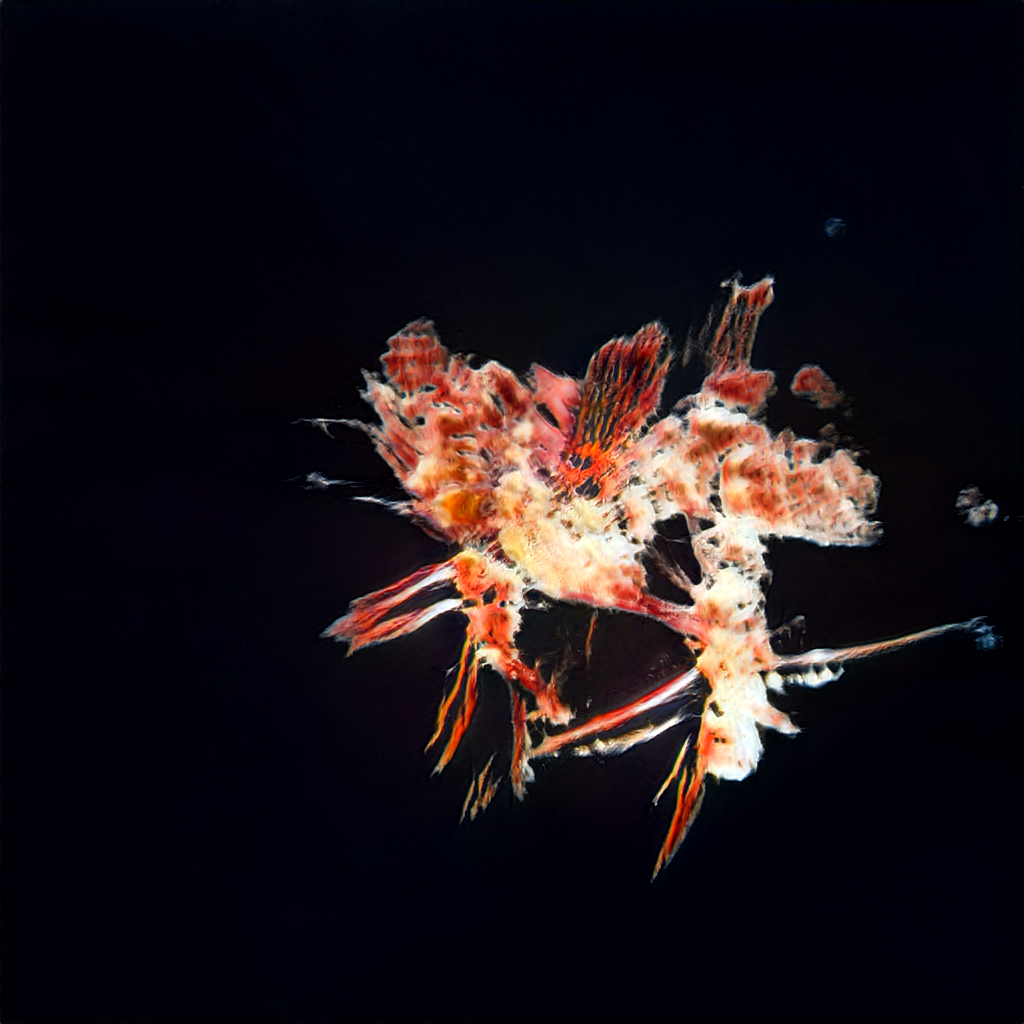

In [ ]:
# Generate a random but realistic image
gen_img(rand_w(1))

Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.


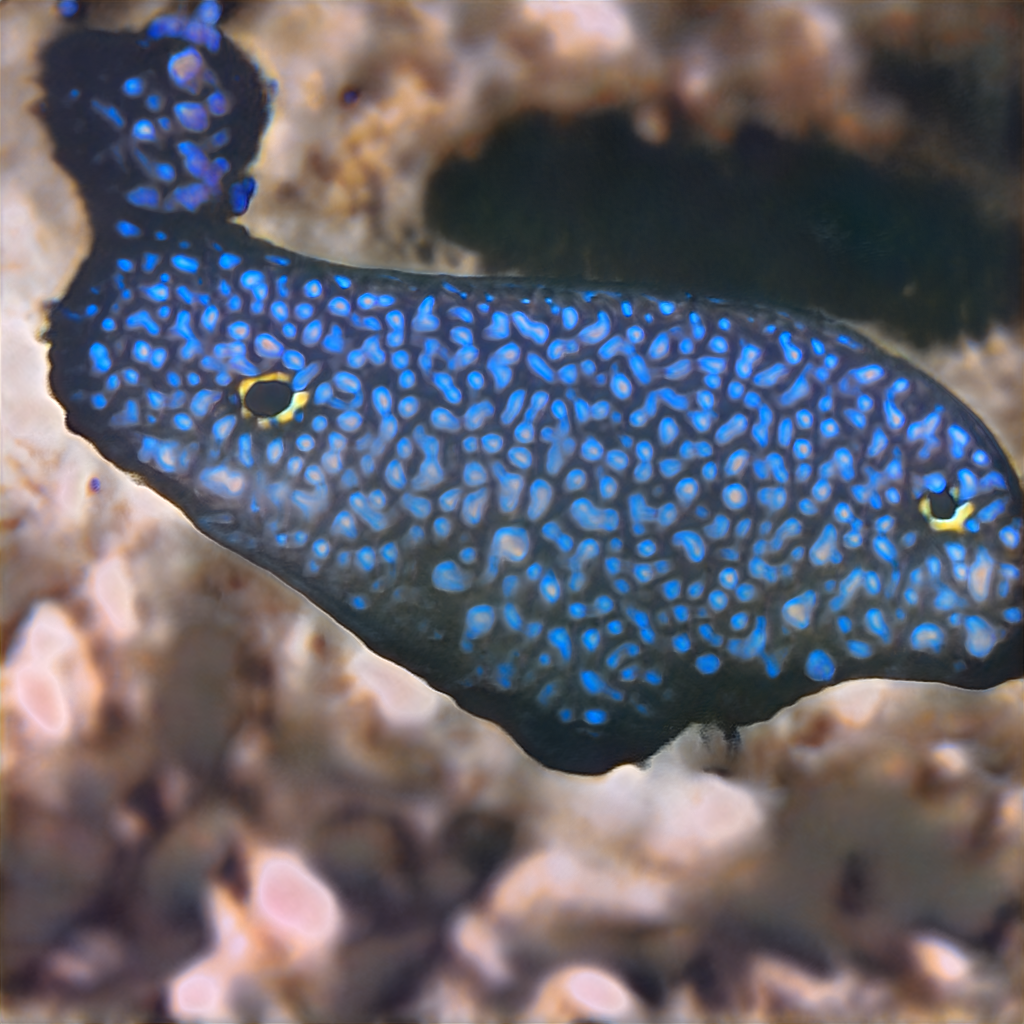

In [ ]:
# Generate a random but exaggerated image
gen_img(rand_w(1.2))

In [ ]:
# uploding the 9 targets for the video series
img_trg1 = upload_img()
img_trg2 = upload_img()
img_trg3 = upload_img()
img_trg4 = upload_img()
img_trg5 = upload_img()
img_trg6 = upload_img()
img_trg7 = upload_img()
img_trg8 = upload_img()
img_trg9 = upload_img()
img_inic = upload_img()

Saving Target_1.png to Target_1 (1).png


Saving Target_2.png to Target_2.png


Saving Target_3.png to Target_3.png


Saving Target_4.png to Target_4.png


Saving Target_5.png to Target_5.png


Saving Target_6.png to Target_6.png


Saving Target_7.png to Target_7.png


Saving Target_8.png to Target_8.png


Saving Target_9.png to Target_9.png


In [ ]:
img_inic = upload_img()
img_trg1 = upload_img()

Saving Inicial.png to Inicial (1).png


Saving Target_1.png to Target_1 (2).png


In [ ]:
img_inic2 = upload_img()

Saving Inicial_2.jpeg to Inicial_2.jpeg


In [ ]:
  # Upload an image and project into latent space
initial_img = projector.project(G, img_inic, num_steps=100, device='cuda')
target1 = projector.project(G, img_trg1, num_steps=1000, device='cuda' ) 
target2 = projector.project(G, img_trg2, num_steps=1000, device='cuda' )
target3 = projector.project(G, img_trg3, num_steps=1000, device='cuda' )
target4 = projector.project(G, img_trg4, num_steps=1000, device='cuda' )
target5 = projector.project(G, img_trg5, num_steps=1000, device='cuda' )
target6 = projector.project(G, img_trg6, num_steps=1000, device='cuda' )
target7 = projector.project(G, img_trg7, num_steps=1000, device='cuda' )
target8 = projector.project(G, img_trg8, num_steps=1000, device='cuda' )
target9 = projector.project(G, img_trg9, num_steps=1000, device='cuda' )


In [ ]:
 initial_img2 = projector.project(G, img_inic2, num_steps=2000, device='cuda')

In [ ]:
target1 = projector.project(G, imga_trg1, num_steps=1000, device='cuda' ) 

In [ ]:
# Generate a video walking around in latent space with (x) key frames
random_latent_walk_video("random.mp4", 4)

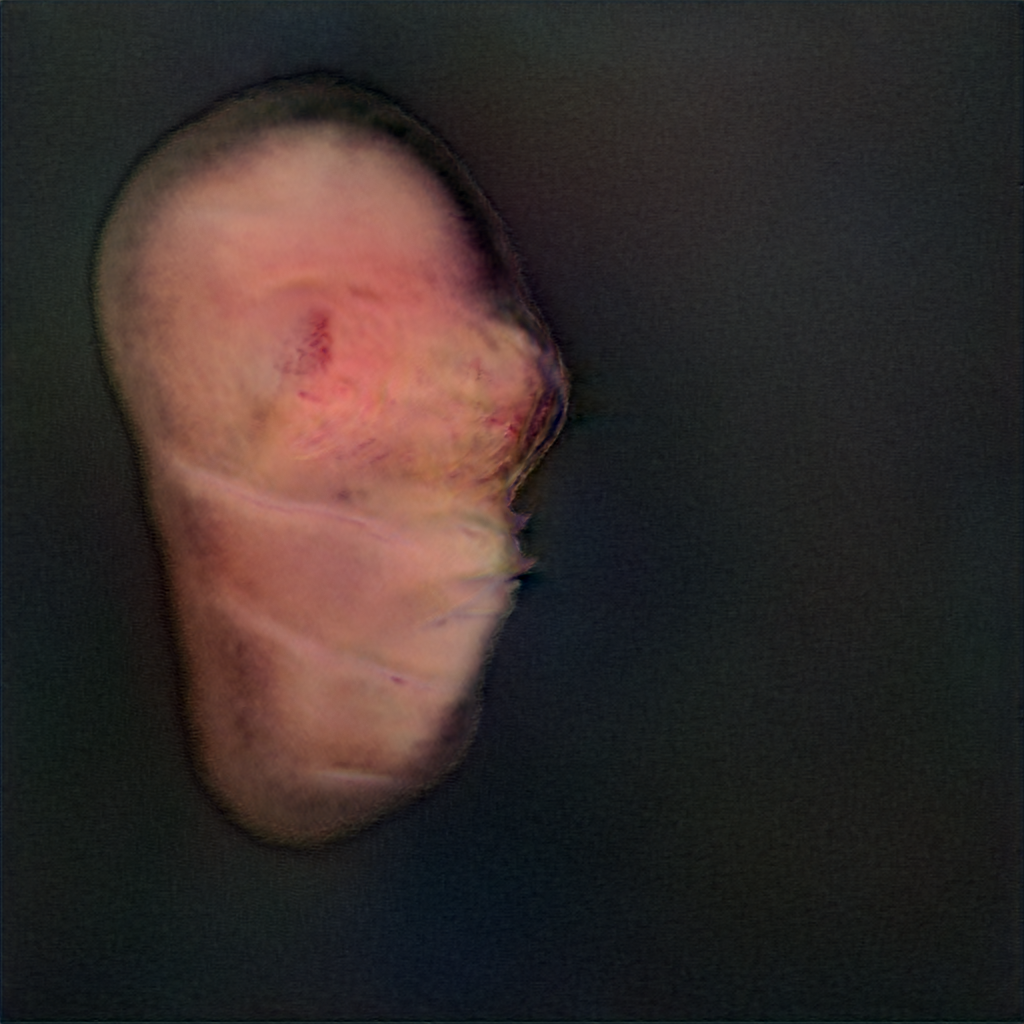

In [ ]:
# Face after 50 steps approximation
gen_img(initial_img2[1999])

In [ ]:
# Face after 200 steps approximation
gen_img(proj[200])

In [ ]:
gen_img(proj[499])

In [ ]:
# Generate a video walking from face 50 to face 200
latent_walk_video('walk1.mp4', initial_img[99], target1[300], 300)
latent_walk_video('walk2.mp4', initial_img[99], target2[900], 300)
latent_walk_video('walk3.mp4', initial_img[99], target3[50], 300)
latent_walk_video('walk4.mp4', initial_img[99], target4[50], 300)
latent_walk_video('walk5.mp4', initial_img[99], target5[150], 300)
latent_walk_video('walk6.mp4', initial_img[99], target6[750], 300)
latent_walk_video('walk7.mp4', initial_img[99], target7[250], 300)
latent_walk_video('walk8.mp4', initial_img[99], target8[50], 300)
latent_walk_video('walk9.mp4', initial_img[99], target9[999], 300)

latent_walk_video('second_walk1.mp4', initial_img2[150], target1[300], 300)
latent_walk_video('second_walk2.mp4', initial_img2[150], target2[900], 300)
latent_walk_video('second_walk3.mp4', initial_img2[150], target3[50], 300)
latent_walk_video('second_walk4.mp4', initial_img2[150], target4[50], 300)
latent_walk_video('second_walk5.mp4', initial_img2[150], target5[150], 300)
latent_walk_video('second_walk6.mp4', initial_img2[150], target6[750], 300)
latent_walk_video('second_walk7.mp4', initial_img2[150], target7[250], 300)
latent_walk_video('second_walk8.mp4', initial_img2[150], target8[50], 300)
latent_walk_video('second_walk9.mp4', initial_img2[150], target9[999], 300)

In [ ]:
edificio = projector.project(G, upload_img(), num_steps=500, device='cuda')

Saving Paisaje_1.jpg to Paisaje_1 (1).jpg


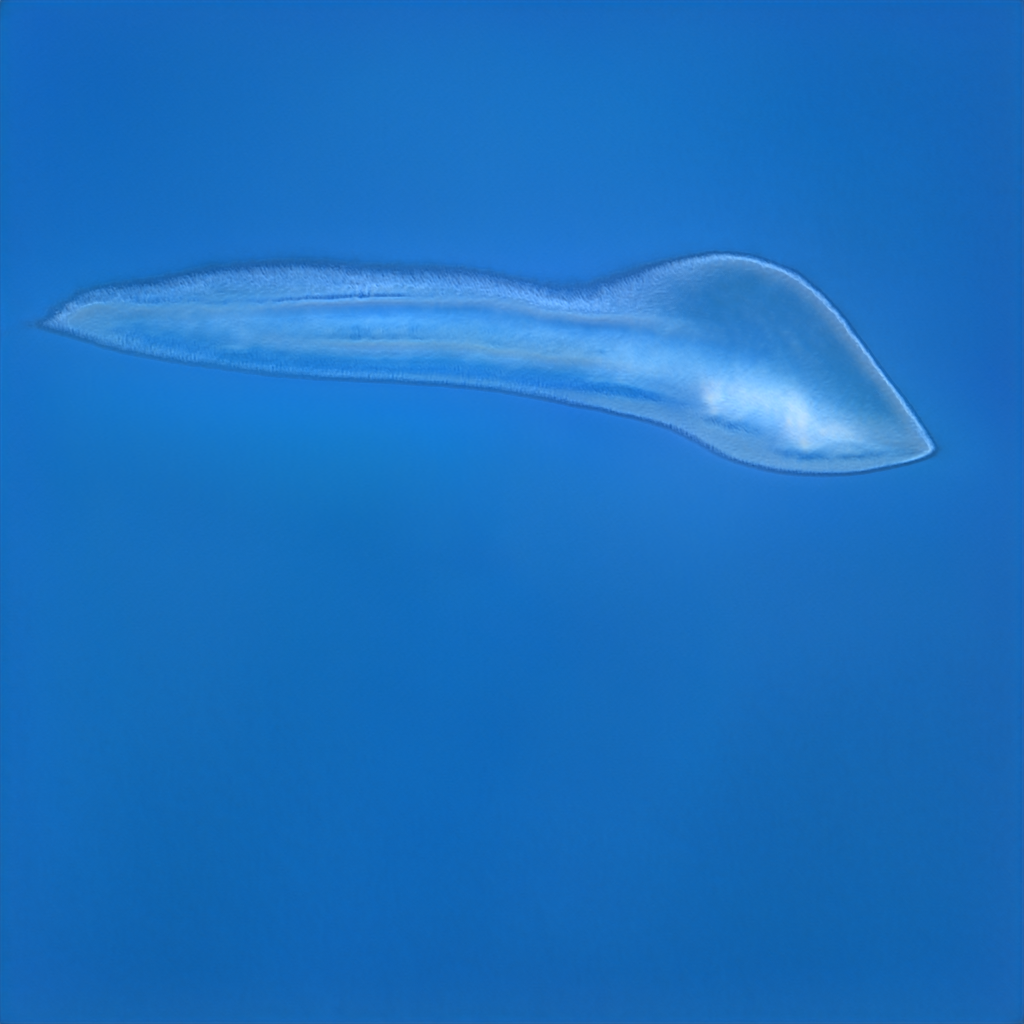

In [ ]:
gen_img(edificio[150])

In [ ]:
latent_walk_video('walk.mp4', proj_1[4], edificio[200], 300)